In [2]:
from read_data import *
from hyper import *
from alignment import *
from copy import *
from datasets.preprecossing import *
import rpy2

folder_path = './datas/100/'
pcanum = 20
tempnum = 200

In [13]:
datas = sc.read_h5ad("./datas/nature/151507_preprocessed.h5")
adata_subset = datas[:tempnum,:]
adata_subset
sc.write('./datas/nature/adata_subset.h5',adata_subset)

In [14]:
datas = sc.read_h5ad("./datas/nature/adata_subset.h5")
count_sub = datas.to_df()
xy_coords = datas.obs[['imagerow',"imagecol"]]
xy_coords.to_csv(folder_path+"xy.csv")
datas.obs.to_csv(folder_path+'meta_data.csv');
count_sub.T.to_csv(folder_path+"gene.csv")

In [15]:
# robjects.r("load(paste0('./datas/pca/DLPFC/LIBD_sample1.RData'))")
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

Spatialpc  = importr('SpatialPCA')
ggplot2 = importr('ggplot2')
matrix = importr('Matrix')
robjects.r("xy_coords <- read.csv('{}',row.names='X')".format(folder_path + 'xy.csv'))
robjects.r("xy_coords=as.matrix(xy_coords)")
robjects.r("count_temp <- read.csv('{}',row.names='X')".format(folder_path + 'gene.csv'))
robjects.r('my_matrix <- do.call(cbind, count_temp)')
robjects.r('my_sparse_matrix <- Matrix(my_matrix, sparse = TRUE)')
robjects.r('count_sub <- as(my_sparse_matrix, "dgCMatrix")')
robjects.r('rownames(count_sub) <- rownames(count_temp)')
robjects.r("rownames(xy_coords) = colnames(count_sub)");
robjects.r('LIBD = CreateSpatialPCAObject(counts=count_sub, location=xy_coords, project = "SpatialPCA",gene.type="spatial",sparkversion="spark",numCores_spark=5,gene.number=3000, customGenelist=NULL,min.loctions = 20, min.features=20)')
robjects.r('LIBD = SpatialPCA_buildKernel(LIBD, kerneltype="gaussian", bandwidthtype="SJ",bandwidth.set.by.user=NULL)')
robjects.r('LIBD = SpatialPCA_EstimateLoading(LIBD,fast=FALSE,SpatialPCnum={})'.format(pcanum))
robjects.r('LIBD = SpatialPCA_SpatialPCs(LIBD, fast=FALSE)')
robjects.r('write.csv(as.data.frame(LIBD@SpatialPCs), file = "{}")'.format(folder_path + "pca.csv"))

## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 4547 by 200

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 200 cells



  |======================================================================| 100%


R[write to console]: Found 20 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 4547 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 4547 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 4.073205 secs

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Centering data matrix

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |==========                                                            |  14%
  |                                                                            
  |====================                                                  |  29%
  |                                                                            
  |==============================                                        |  43%
  |                                                                         

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  200 
## number of total features:  4547 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  27  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  27  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.292332161645348  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1] 

In [3]:
adata1 = pd.read_csv(folder_path+"pca.csv")
adata1 = adata1.set_index(adata1.columns[0]).T
adata1.index = adata1.index.str.replace('.', '-')
adata1 = anndata.AnnData(adata1)

cell_meta = pd.read_csv(folder_path+"meta_data.csv")
cell_meta = cell_meta.set_index(cell_meta.columns[0])
adata1.obs = cell_meta
adata1.obsm['X_pca'] = adata1.to_df()
# # adata1.obs['celltype'] = cell_meta.values




/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_2515/953224956.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  adata1.index = adata1.index.str.replace('.', '-')
/var/folders/bm/69jvgsdj3rxch558kx9yp9y00000gn/T/ipykernel_2515/953224956.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1 = anndata.AnnData(adata1)
/Users/dongjiajie/opt/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
adata1.raw = adata1

sc.pp.neighbors(adata1,
                n_neighbors=10,
                use_rep='X_pca',
                random_state=1234
                )
sc.tl.diffmap(adata1,random_state=1234)
sc.tl.umap(adata1,random_state=1234)
sc.tl.leiden(adata1,random_state=1234,resolution = 0.5)
sc.tl.paga(adata1, groups='leiden')


In [5]:
set_initial_condition(adata1);


In [9]:
inter_gene = sort_data(adata1,adata1,N_1=None,N_2=None)

20 genes are used to calculate cost of tree alignment.



In [10]:
calculate_cluster_centroid_for_genes

<function datasets.preprecossing.calculate_cluster_centroid_for_genes(adata, gene_list, save_path='./')>

In [11]:
tmp1 = calculate_cluster_centroid_for_genes(adata1,inter_gene,folder_path)
tmp1

Unnamed: 0,14,12,8,20,7,11,10,17,15,4,9,16,13,3,19,18,6,1,2,5
0,0.009051,0.058077,-0.059376,-0.027626,0.032239,-0.068692,-0.049867,-0.051191,-0.017536,0.654518,0.012877,0.091667,0.003486,0.031007,-0.047576,-0.048289,-0.147984,-0.683366,-0.989495,-0.283160
1,-0.124950,-0.003554,0.015949,0.061365,-0.130042,0.017970,0.137041,-0.052216,-0.054183,-0.154403,0.054424,-0.030386,0.000832,0.485355,0.034002,-0.054263,-0.098234,2.317916,-0.969082,-0.261546
2,0.037830,-0.082863,0.223970,-0.038795,-0.219654,-0.100413,-0.024834,-0.057525,0.023720,0.480452,0.088541,0.084264,-0.068463,0.035902,0.018377,0.019877,0.095330,1.858348,1.294131,0.104257
3,-0.027793,0.171696,0.112044,0.061204,-0.272885,0.070353,0.133708,0.016282,-0.024882,0.118350,-0.103040,-0.028128,0.217613,-0.891631,0.031625,0.013471,-0.200543,-1.589582,-0.000354,0.203994
4,-0.127910,-0.031612,-0.306302,-0.001434,0.213139,0.159975,0.039286,-0.044053,0.073275,-0.329834,-0.255850,0.054622,-0.215506,-1.179123,0.013490,0.094283,0.115335,0.911811,0.681948,-0.416150
5,-0.120746,-0.096987,0.105657,-0.016911,-0.086679,0.132877,-0.010666,0.019035,-0.099313,-0.440923,0.073764,0.131184,-0.180555,0.918050,0.048060,0.078580,0.504480,-3.861951,0.221137,-0.184866
6,0.005984,0.428380,-0.172018,-0.009298,0.276590,0.184855,0.214871,0.115488,-0.134856,0.008810,0.003545,0.056173,0.171465,0.594852,-0.090794,0.049427,0.664249,2.461003,0.075193,0.191449
7,-0.028616,0.069203,-0.168605,0.118220,0.272525,-0.428198,0.073927,0.008549,-0.016306,-0.457354,0.111175,0.214242,-0.025847,0.768211,-0.051137,0.144660,-0.681990,0.060098,0.323517,-0.092057


./datas/100/datas.data length:8
Generating all pairs superset


100%|██████████| 1563/1563 [01:07<00:00, 23.17ex/s, loss=0.736654] 


	 Epoch 9 | average train loss: 0.774674
Optimization finished.


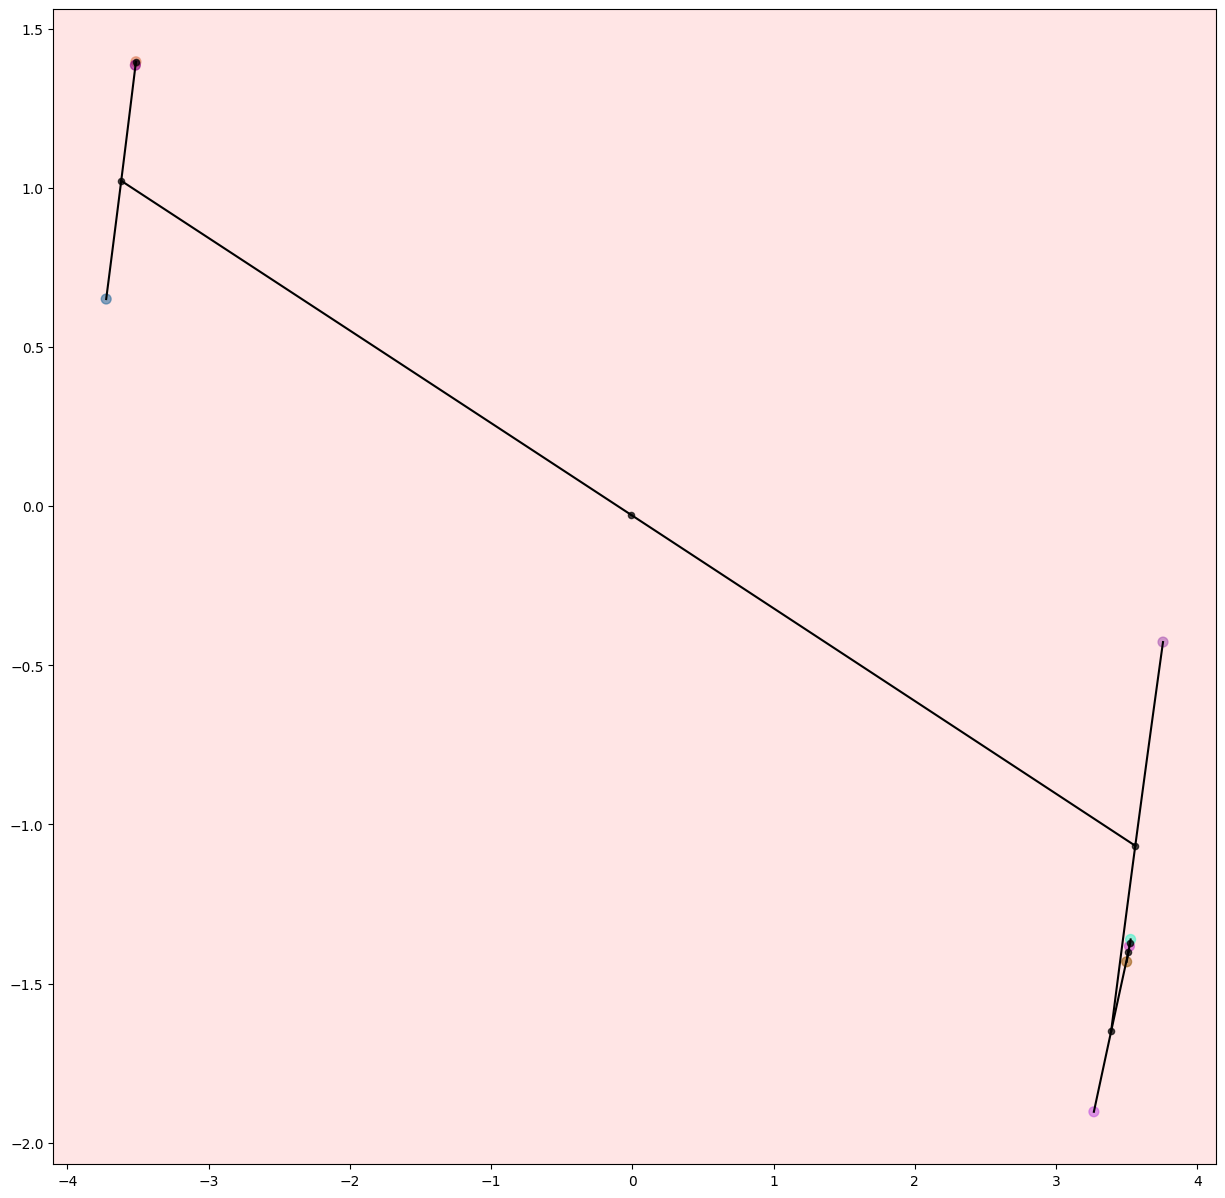

In [12]:
get_Hyper_tree(folder_path+'datas.data',1,tmp1.shape[1]+1,0,10,model_path=None,save_path=folder_path,c=0)


In [12]:
nodes1,n1 = build_hyper_tree('./datas/1/')
# show_tree(nodes1[0]).show_fig()
nodes2,n2 = build_hyper_tree('./datas/2/')
# show_tree(nodes2[0]).show_fig()
T=tree_alignment(nodes1[0],nodes2[0],1);
minn = T.run_alignment();
T.show_ans();
ans = T.get_ans()
G=show_graph(ans,nodes1[0],nodes2[0]);
# G.show_fig()
print("average cost for one node:{}".format(minn/(n1+n2)))

The mininum cost for alignment is 33.64812030075188
The alignment edges list is [('26', '30'), ('25', '28'), ('3', '4'), ('14', '17'), ('4', '2'), ('2', '0'), ('24', '27'), ('23', '26'), ('22', '23'), ('17', '21'), ('15', '20'), ('9', '10'), ('1', '15'), ('7', '13'), ('11', '7'), ('18', '18'), ('10', '6'), ('6', '14'), ('21', '22'), ('19', '16'), ('8', '11'), ('0', '1'), ('5', '8')]
average cost for one node:0.5801400051853772


In [11]:
label1 = pd.read_csv("./datas/1/leiden.csv")
label1 = label1.set_index(label1.columns[0])
label1
label2 = pd.read_csv("./datas/2/leiden.csv")
label2 = label2.set_index(label2.columns[0])
label2

,leiden
Unnamed: 0,
AAACAACGAATAGTTC-1,3
AAACAAGTATCTCCCA-1,7
AAACAATCTACTAGCA-1,0
AAACACCAATAACTGC-1,4
AAACAGCTTTCAGAAG-1,13
...,...
TTGTTGTGTGTCAAGA-1,11
TTGTTTCACATCCAGG-1,10
TTGTTTCATTAGTCTA-1,4


In [14]:
all = len(label1);
count =0;
for i in range(len(label1)):
    l1 = label1.iloc[i][0];
    l2 = label2.iloc[i][0];
    if(ans.__contains__( (str(l1),str(l2)) ) ):
        count +=1
print(count/all);

0.17677725118483412


In [37]:
preprocessing_st_cluster(datas)
# set_initial_condition(datas)



         Falling back to preprocessing with `sc.pp.pca` and default params.


In [46]:
datas.obsm['X_pca'].shape

(4220, 50)

In [9]:
datas.obs

,in_tissue,array_row,array_col,imagerow,imagecol,sum_umi,sum_gene,subject,position,replicate,...,layer_guess_reordered_short,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,n_counts
AAACAACGAATAGTTC-1,1,0,16,113.141318,147.434749,948,727,Br5292,0,1,...,L1,727,6.590301,948.0,6.855409,22.362869,32.911392,44.409283,76.054852,914.0
AAACAAGTATCTCCCA-1,1,50,102,383.438357,413.051319,4261,2170,Br5292,0,1,...,L3,2170,7.682943,4261.0,8.357493,24.994133,31.471486,40.154893,56.817648,4166.0
AAACAATCTACTAGCA-1,1,3,43,129.522957,231.008109,1969,1093,Br5292,0,1,...,L1,1093,6.997596,1969.0,7.585789,34.128999,42.001016,52.158456,69.883189,1904.0
AAACACCAATAACTGC-1,1,59,19,431.188134,155.805586,3368,1896,Br5292,0,1,...,WM,1896,7.548029,3368.0,8.122372,22.446556,29.928741,39.994062,58.491686,3229.0
AAACAGCTTTCAGAAG-1,1,43,9,344.869499,125.067511,2981,1620,Br5292,0,1,...,L6,1620,7.390799,2981.0,8.000349,27.172090,34.149614,44.112714,62.428715,2909.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,280.783088,335.913603,2337,1320,Br5292,0,1,...,L3,1320,7.186144,2337.0,7.757051,30.851519,38.040223,47.411211,64.912281,2286.0
TTGTTTCACATCCAGG-1,1,58,42,426.012616,227.047713,2331,1444,Br5292,0,1,...,L6,1444,7.275865,2331.0,7.754481,22.779923,30.072930,40.669241,59.502360,2267.0
TTGTTTCATTAGTCTA-1,1,60,30,436.678683,189.828989,819,629,Br5292,0,1,...,WM,629,6.445720,819.0,6.709304,25.030525,35.409035,47.619048,84.249084,784.0
TTGTTTCCATACAACT-1,1,45,27,355.805593,180.783085,3092,1697,Br5292,0,1,...,L6,1697,7.437206,3092.0,8.036897,25.582147,32.794308,42.658473,61.287193,3015.0


In [5]:
test =  pd.read_csv('./datas/719/pca.csv')
test = test.set_index(test.columns[0])
test

,AAACAACGAATAGTTC.1,AAACAAGTATCTCCCA.1,AAACAATCTACTAGCA.1,AAACACCAATAACTGC.1,AAACAGCTTTCAGAAG.1,AAACAGGGTCTATATT.1,AAACAGTGTTCCTGGG.1,AAACATTTCCCGGATT.1,AAACCACTACACAGAT.1,AAACCCGAACGAAATC.1,...,TTGTGTATGCCACCAA.1,TTGTGTTTCCCGAAAG.1,TTGTTAGCAAATTCGA.1,TTGTTCAGTGTGCTAC.1,TTGTTCTAGATACGCT.1,TTGTTGTGTGTCAAGA.1,TTGTTTCACATCCAGG.1,TTGTTTCATTAGTCTA.1,TTGTTTCCATACAACT.1,TTGTTTGTGTAAATTC.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1,-1.742179,4.208592,-8.122478,-15.563433,2.585480,-0.571400,-4.745038,1.989525,4.170938,2.596544,...,1.601800,3.069908,3.371156,3.153809,0.210978,3.602209,-0.240509,-10.261098,1.487125,-4.602841
2,-0.050372,-0.188750,8.238340,-8.868978,-1.649134,-2.296564,-4.615797,-3.802923,4.961100,1.048257,...,-3.100365,-4.016083,1.147432,2.833683,-2.487486,2.274316,-3.556936,-7.747452,-2.249188,6.964852
3,0.172844,-0.850747,-2.817448,5.220857,-0.027134,1.547148,0.705489,-1.896522,3.747851,-0.011553,...,-0.823501,-0.971786,0.185960,1.740142,-1.298287,0.859793,1.898851,1.222923,-0.216891,-1.650097
4,2.192438,-0.732998,-3.844993,-4.435772,-0.087575,0.318647,-0.741601,2.685640,0.726184,1.815685,...,-0.876923,-0.442207,-2.325353,-0.456158,1.443258,-1.887574,-0.375175,2.723484,-0.783052,-2.024797
5,-0.777553,1.336927,-1.577289,2.248321,-3.085096,-2.976059,-0.005429,-0.696005,0.332314,1.767681,...,-1.941323,-1.270356,1.915761,0.838848,-0.092483,1.028837,-2.388757,2.947516,-1.696337,-0.920072
6,-4.132174,1.366941,-0.367433,1.530303,-1.255844,-0.580191,-0.992041,2.105831,1.580622,2.309779,...,1.348670,1.146837,0.326176,0.435541,-2.056775,0.160600,0.033545,-2.285964,-0.783625,-0.299170
7,1.636083,1.130777,-0.526728,-0.325219,1.381870,0.562941,-0.268462,-1.688192,-1.313471,1.031371,...,-1.471882,-1.323629,-0.014936,0.389861,2.197608,-0.779891,-0.173732,-0.099366,-1.163087,-2.350509
8,1.739748,-0.353206,0.374770,-1.786930,-1.967390,-1.827987,1.113099,-0.393713,-1.294134,-1.056978,...,1.341084,0.830147,-0.017597,0.002471,-0.872782,0.649933,1.782998,1.651121,-0.376955,-0.495665
9,0.270036,-0.060463,1.681578,-0.099736,-3.015521,-2.413598,0.336453,0.352749,1.674870,-0.029065,...,-0.284918,-0.006385,-0.070385,-0.973102,0.627318,0.058348,-1.256519,-2.607931,0.232594,-0.056054


In [ ]:
get_Hyper_tree()